# Get polarization signature

Data source: Ota et al., Cell 2021, Hollbacher et al., Immunohorizons 2021, Diff043 scRNAseq

In [11]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad

import pertpy
#import pert2state_model

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

To download processed data:
```bash
DROPBOX_PATH=GRNPerturbSeq/3_expts/Diff035scRNAseq/
DATADIR=/mnt/oak/users/emma/data/GWT/

rclone copy dropbox:${DROPBOX_PATH}Diff035_pseudobulk.h5ad ${DATADIR} --checksum --ignore-times
rclone copy dropbox:${DROPBOX_PATH}Diff035_merged.gex.filtered.h5ad ${DATADIR} --checksum --ignore-times
```

### Process Hollbacher et al 2021 RNAseq

In [91]:
DATADIR = '../../../../2_files'

In [145]:
hollbacher_df = pd.read_csv(f'{DATADIR}/Hollbacher_et_al_2021/Hollbacher_et_al_Th1_Th2.csv', index_col='gene_name')

In [151]:
# Parse into anndata in preparation for DESeq2
obs_metadata = pd.DataFrame({'donor_id': [item[0] for item in hollbacher_df.columns.str.split('_')],
                            'cell_subset': [item[1] for item in hollbacher_df.columns.str.split('_')]},
                            index=hollbacher_df.columns)
adata_hollbacher = anndata.AnnData(X=hollbacher_df.T.astype(int),
                                   obs=obs_metadata,
                                   var=pd.DataFrame(hollbacher_df.index, index=hollbacher_df.index))
adata_hollbacher.var['mean_expression'] = adata_hollbacher.X.mean(axis=0)
adata_hollbacher = adata_hollbacher[:, adata_hollbacher.var['mean_expression'] > 10].copy()

In [152]:
model = pertpy.tl.PyDESeq2(adata_hollbacher, design='~cell_subset')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

test_st = 'Th2'
control_st = 'Th1'
polariz_contrast = (model.cond(cell_subset=test_st) - model.cond(cell_subset=control_st)) 
res_df = model.test_contrasts(polariz_contrast)
res_df['contrast'] = test_st + '_vs_' + control_st
# Store the result dataframe in our list
result_dfs.append(res_df)

all_results_hollbacher_df = pd.concat(result_dfs)

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 1.]
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_name                                                                     
A1BG         52.379421        0.728716  0.381154  1.911867  0.055893  0.999978
AAAS        182.152273       -0.075704  0.358319 -0.211275  0.832673  0.999978
AACS        184.440329       -0.068119  0.348104 -0.195685  0.844857  0.999978
AAED1       339.503734        0.223490  0.321522  0.695099  0.486994  0.999978
AAGAB       347.106643       -0.090706  0.208642 -0.434745  0.663748  0.999978
...                ...             ...       ...       ...       ...       ...
ZXDC        594.766705        0.042525  0.247044  0.172134  0.863332  0.999978
ZYG11B      484.911034        0.011320  0.267449  0.042324  0.966240  0.999978
ZYX        1638.805685        0.476234  0.360544  1.320875  0.186543  0.999978
ZZEF1      2494.774565       -0.020579  0.226955 -0.090673  0.927752

... done in 0.26 seconds.



NaNs encountered, dropping rows with NaNs


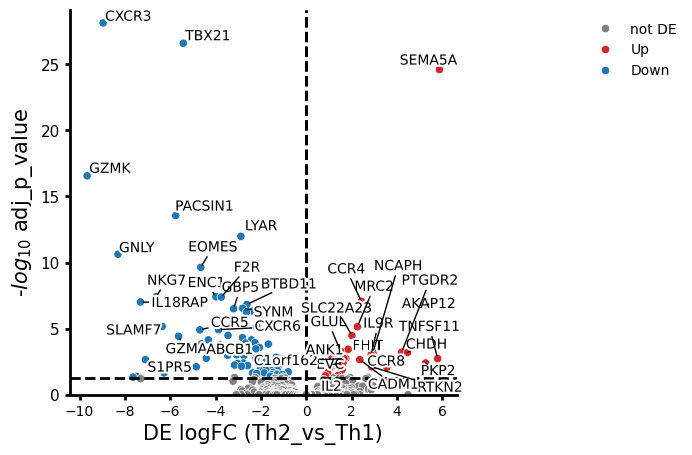

In [161]:
res_df = all_results_hollbacher_df[all_results_hollbacher_df.contrast=='Th2_vs_Th1'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    x_label=f"DE logFC ({p})",
    to_label = 20,
    )

In [158]:
all_results_hollbacher_df['zscore'] = all_results_hollbacher_df['log_fc'] / all_results_hollbacher_df['lfcSE']
all_results_ota_df.to_csv("results/hollbacher_Th2vsTh1_DE_results.csv", index=False)

### Process Ota et al 2021 RNAseq

In [2]:
DATADIR = '../../../../2_files'

In [3]:
# Load sample information, memory CD4, Th1 and Th2 RNAseq
sample_info = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/clinical_diagnosis_age_sex_v2.txt', delimiter='\t')
ota_Th1 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th1_count.txt', delimiter='\t')
ota_Th2 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th2_count.txt', delimiter='\t')

# Select phase 2 healthy control samples
mask = (sample_info.disease=='HC') & (sample_info.Phase==2)
sample_HC_p2 = sample_info[mask].id.values

# Find common samples across all subsets
sample_common = list(set(sample_HC_p2) & set(ota_Th1.columns) & set(ota_Th2.columns))
columns_to_get = ['Gene_id', 'Gene_name'] + sample_common

ota_Th1_HC_p2 = ota_Th1[columns_to_get].copy()
ota_Th2_HC_p2 = ota_Th2[columns_to_get].copy()

# Parse into anndata in preparation for DESeq2
obs_metadata = pd.DataFrame({'cell_subset': 'Th1',
                             'donor_id': ota_Th1_HC_p2.columns[2:]},
                            index='Th1_'+ota_Th1_HC_p2.columns[2:])
adata_ota_Th1 = anndata.AnnData(X=ota_Th1_HC_p2.iloc[:,2:].T.reset_index(drop=True),
                                obs=obs_metadata,
                                var=ota_Th1_HC_p2.iloc[:,:2])

obs_metadata = pd.DataFrame({'cell_subset': 'Th2',
                             'donor_id': ota_Th2_HC_p2.columns[2:]},
                            index='Th2_'+ota_Th2_HC_p2.columns[2:])
adata_ota_Th2 = anndata.AnnData(X=ota_Th2_HC_p2.iloc[:,2:].T.reset_index(drop=True),
                                obs=obs_metadata,
                                var=ota_Th2_HC_p2.iloc[:,:2])

adata_ota = anndata.concat([adata_ota_Th1, adata_ota_Th2])
adata_ota.var = adata_ota_Th1.var.copy()
adata_ota.var.index = adata_ota.var['Gene_name']
adata_ota.var_names_make_unique()
obs_temp = adata_ota.obs.copy()
obs_update = pd.merge(obs_temp, sample_info, how='inner', left_on='donor_id', right_on='id')
obs_update = obs_update[['cell_subset', 'donor_id', 'age', 'sex']]
obs_update.index = adata_ota.obs.index
adata_ota.obs = obs_update.copy()
sc.pp.filter_genes(adata_ota, min_counts=100)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_86661/3948188069.py:35: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`. Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-5', 'SNORD113-6']
  adata_ota.var_names_make_unique()


In [4]:
# # Load sample information, memory CD4, Th1 and Th2 RNAseq
# sample_info = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/clinical_diagnosis_age_sex_v2.txt', delimiter='\t')
# ota_memCD4 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Mem_CD4_count.txt', delimiter='\t')
# ota_Th1 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th1_count.txt', delimiter='\t')
# ota_Th2 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th2_count.txt', delimiter='\t')
# ota_Th17 = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Th17_count.txt', delimiter='\t')
# ota_Tfh = pd.read_csv(f'{DATADIR}/Ota_et_al_2021/E-GEAD-397.processed/Tfh_count.txt', delimiter='\t')

# # Select phase 2 healthy control samples
# mask = (sample_info.disease=='HC') & (sample_info.Phase==2)
# sample_HC_p2 = sample_info[mask].id.values

# # Find common samples across all subsets
# sample_common = list(set(sample_HC_p2) & set(ota_memCD4.columns) & set(ota_Th1.columns) & set(ota_Th2.columns) & set(ota_Th17.columns) & set(ota_Tfh.columns))
# columns_to_get = ['Gene_id', 'Gene_name'] + sample_common

# ota_memCD4_HC_p2 = ota_memCD4[columns_to_get].copy()
# ota_Th1_HC_p2 = ota_Th1[columns_to_get].copy()
# ota_Th2_HC_p2 = ota_Th2[columns_to_get].copy()
# ota_Th17_HC_p2 = ota_Th17[columns_to_get].copy()
# ota_Tfh_HC_p2 = ota_Tfh[columns_to_get].copy()

# # Parse into anndata in preparation for DESeq2
# obs_metadata = pd.DataFrame({'cell_subset': 'memCD4',
#                              'donor_id': ota_memCD4_HC_p2.columns[2:]},
#                             index='memCD4_'+ota_memCD4_HC_p2.columns[2:])
# adata_ota_memCD4 = anndata.AnnData(X=ota_memCD4_HC_p2.iloc[:,2:].T.reset_index(drop=True),
#                                    obs=obs_metadata,
#                                    var=ota_memCD4_HC_p2.iloc[:,:2])

# obs_metadata = pd.DataFrame({'cell_subset': 'AllbutTh1',
#                              'donor_id': ota_Th2_HC_p2.columns[2:]},
#                             index='AllbutTh1_'+ota_Th2_HC_p2.columns[2:])
# combined_data = (ota_Th2_HC_p2.iloc[:,2:]+ota_Th17_HC_p2.loc[:,ota_Th2_HC_p2.columns[2:]]\
#                  +ota_Tfh_HC_p2.loc[:,ota_Th2_HC_p2.columns[2:]]).T.reset_index(drop=True)
# adata_ota_AllbutTh1 = anndata.AnnData(X=combined_data,
#                                 obs=obs_metadata,
#                                 var=ota_Th2_HC_p2.iloc[:,:2])

# obs_metadata = pd.DataFrame({'cell_subset': 'AllbutTh2',
#                              'donor_id': ota_Th1_HC_p2.columns[2:]},
#                             index='AllbutTh2_'+ota_Th1_HC_p2.columns[2:])
# combined_data = (ota_Th1_HC_p2.iloc[:,2:]+ota_Th17_HC_p2.loc[:,ota_Th1_HC_p2.columns[2:]]\
#                  +ota_Tfh_HC_p2.loc[:,ota_Th1_HC_p2.columns[2:]]).T.reset_index(drop=True)
# adata_ota_AllbutTh2 = anndata.AnnData(X=combined_data,
#                                 obs=obs_metadata,
#                                 var=ota_Th1_HC_p2.iloc[:,:2])

In [5]:
flex_gene_df = pd.read_csv(f'{DATADIR}/Chromium_Human_Transcriptome_Probe_Set_v1.1.0_GRCh38-2024-A_notitle.csv')
flex_gene = flex_gene_df[flex_gene_df.included==True].gene_name.unique()

In [6]:
len(flex_gene), len(set(flex_gene)&set(adata_ota.var.Gene_name.values)), len(set(adata_ota.var.Gene_name.values))

(18129, 11906, 20586)

In [7]:
model = pertpy.tl.PyDESeq2(adata_ota, design='~cell_subset+sex')
model.fit(quiet=True)

# Create a list to store all result dataframes
result_dfs = []

test_st = 'Th2'
control_st = 'Th1'
polariz_contrast = (model.cond(cell_subset=test_st) - model.cond(cell_subset=control_st)) 
res_df = model.test_contrasts(polariz_contrast)
res_df['contrast'] = test_st + '_vs_' + control_st
# Store the result dataframe in our list
result_dfs.append(res_df)

all_results_ota_df = pd.concat(result_dfs)

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 1. 0.]
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
Gene_name                                                                   
DPM1        507.837325        0.023657  0.029976   0.789195  4.299979e-01   
SCYL3       458.637208        0.075242  0.032523   2.313475  2.069656e-02   
C1orf112    100.127522        0.183857  0.061265   3.001009  2.690870e-03   
FGR          49.924422       -5.293542  0.348105 -15.206760  3.189422e-52   
CFH         161.428537       -2.001661  0.160929 -12.438128  1.622621e-35   
...                ...             ...       ...        ...           ...   
AC116562.4    5.866578       -0.241181  0.290263  -0.830907  4.060260e-01   
AC099063.4   80.416871       -0.486419  0.055712  -8.730951  2.525402e-18   
AL139424.3    2.738921       -0.142232  0.221686  -0.641592  5.211379e-01   
AL358472.5    6.738003       -0.076995  0.131602  -0.585062  5.585058e-01   
AL034417.4

... done in 0.63 seconds.



0s encountered for p value, replacing with 1e-323


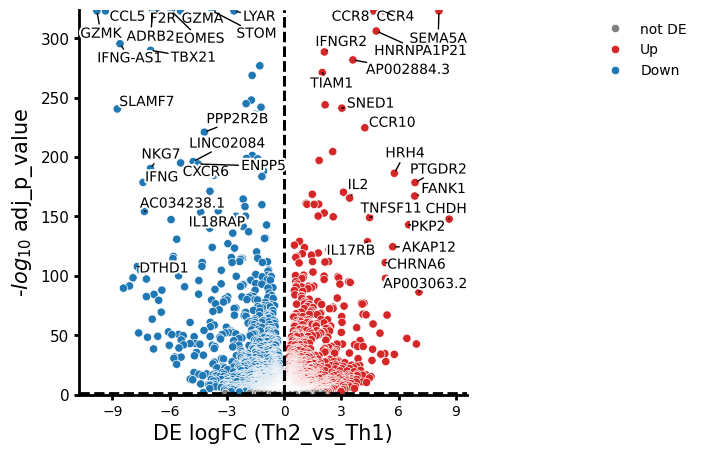

In [159]:
res_df = all_results_ota_df[all_results_ota_df.contrast=='Th2_vs_Th1'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    x_label=f"DE logFC ({p})",
    to_label = 20,
    )

In [9]:
all_results_ota_df['zscore'] = all_results_ota_df['log_fc']/all_results_ota_df['lfcSE']
all_results_ota_df.to_csv("results/Ota_Th2vsTh1_DE_results.csv", index=False)

## DE analysis on polarization experiments

In [10]:
DATADIR = '../../../../3_expts'

In [12]:
adata_Th1 = sc.read_h5ad(f'{DATADIR}/Diff043scRNAseq/Diff043_Th1_merged.gex.filtered.h5ad')
adata_Th2 = sc.read_h5ad(f'{DATADIR}/Diff043scRNAseq/Diff043_Th2_merged.gex.filtered.h5ad')
adata = ad.concat([adata_Th1, adata_Th2])
adata.var = adata_Th1.var.copy()
adata.obs['sample_id'] = adata.obs.timepoint.astype(str) + '_' + adata.obs.donor.astype(str) + '_' + adata.obs.culture_condition.astype(str)
sc.pp.filter_genes(adata, min_cells=1000)

In [15]:
unique_conditions = adata.obs['sample_id'].unique()

train_indices = []
test_indices = []
# Split each condition separately to maintain balance
for condition in unique_conditions:
    condition_indices = adata.obs[adata.obs['sample_id'] == condition].index
    train_idx, test_idx = train_test_split(
        condition_indices,
        test_size=0.25,
        random_state=42
    )
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

adata.obs['split'] = 'train'
adata.obs.loc[test_indices, 'split'] = 'test'

print(adata.obs.groupby(['sample_id', 'split']).size().unstack())

split            test  train
sample_id                   
Rest_D1_Th1      1414   4239
Rest_D1_Th2      1619   4857
Rest_D2_Th1       557   1671
Rest_D2_Th2      1516   4548
Rest_D3_Th1      1520   4557
Rest_D3_Th2      1781   5340
Rest_D4_Th1      1124   3370
Rest_D4_Th2       628   1882
Stim48hr_D1_Th1  1675   5025
Stim48hr_D1_Th2   638   1912
Stim48hr_D2_Th1  1451   4350
Stim48hr_D2_Th2  1919   5756
Stim48hr_D3_Th1  1313   3938
Stim48hr_D3_Th2  2018   6051
Stim48hr_D4_Th1  1798   5391
Stim48hr_D4_Th2  2937   8808
Stim8hr_D1_Th1   1241   3721
Stim8hr_D1_Th2   1719   5156
Stim8hr_D2_Th1    875   2625
Stim8hr_D2_Th2   1338   4013
Stim8hr_D3_Th1   1361   4081
Stim8hr_D3_Th2   2120   6359
Stim8hr_D4_Th1    722   2165
Stim8hr_D4_Th2   1774   5319


In [16]:
# Pseudobulking and feature selection
adata_train = adata[adata.obs['split'] == 'train'].to_memory()
pbulk_adata = sc.get.aggregate(adata_train, by=['timepoint', 'donor', 'culture_condition'], func=['sum'])

# Filter out lowly expressed genes
#pbulk_adata.var['mean_expression'] = pbulk_adata.layers['sum'].mean(axis=0)
#pbulk_adata = pbulk_adata[:, pbulk_adata.var['mean_expression'] > 1].copy()
# Filter out mitochrondria genes
pbulk_adata = pbulk_adata[:,~pbulk_adata.var.gene_name.str.startswith('MT-')].copy()
pbulk_adata.X = pbulk_adata.layers['sum'].copy()

# Process test dataset
adata_test = adata[adata.obs['split'] == 'test'].to_memory()
adata_test = adata_test[:, pbulk_adata.var_names].copy()
pbulk_adata_test = sc.get.aggregate(adata_test, by=['timepoint', 'donor', 'culture_condition'], func=['sum'])
pbulk_adata_test.X = pbulk_adata_test.layers['sum'].copy()

In [17]:
tps = ['Rest', 'Stim8hr', 'Stim48hr']
result_dfs = []
repl_result_dfs = []

for tp in tps:
    tp_mask = adata.obs['timepoint']==tp
    pbulk_adata_subset = pbulk_adata[pbulk_adata.obs.timepoint==tp].copy()
    pbulk_adata_test_subset = pbulk_adata_test[pbulk_adata_test.obs.timepoint==tp].copy()

    # Fit DESeq2 model
    model = pertpy.tl.PyDESeq2(pbulk_adata_subset, design='~donor+culture_condition', layer='sum')
    model.fit(quiet=True)
    polariz_contrast = (model.cond(culture_condition='Th2') - model.cond(culture_condition='Th1')) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = 'Th2_vs_Th1_' + tp
    # Store the result dataframe in our list
    result_dfs.append(res_df)
    
    # Fit DESeq2 model
    model = pertpy.tl.PyDESeq2(pbulk_adata_test_subset, design='~donor+culture_condition', layer='sum')
    model.fit(quiet=True)
    polariz_contrast = (model.cond(culture_condition='Th2') - model.cond(culture_condition='Th1')) 
    res_df = model.test_contrasts(polariz_contrast)
    res_df['contrast'] = 'Th2_vs_Th1_' + tp
    # Store the result dataframe in our list
    repl_result_dfs.append(res_df)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Running Wald tests...
... done in 0.47 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    1458.731027       -0.005397  0.118210 -0.045654  0.963586  0.981010
KLHL17    175.097206       -0.504491  0.222948 -2.262819  0.023647  0.070959
PLEKHN1   137.029423       -0.572259  0.274848 -2.082089  0.037334  0.102203
ISG15    5466.445869       -0.106341  0.091564 -1.161381  0.245487  0.421550
AGRN       65.143474       -0.479035  0.346120 -1.384014  0.166354  0.318617
...              ...             ...       ...       ...       ...       ...
USP9Y     157.263196       -0.642511  0.633169 -1.014755  0.310223  0.493450
DDX3Y     744.579849        0.133580  0.389648  0.342822  0.731732  0.839839
UTY       386.753832       -0.340979  0.384920 -0.885842  0.375703  0.558618
KDM5D     723.581366       -0.369243  0.883744 -0.417816  0.676082  0.803624
EIF1AY   2239.508017        0.300647  0.258565  1.162753  0.244930  0.420974

[11

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Running Wald tests...
... done in 0.43 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L     520.463307       -0.020658  0.156377 -0.132104  0.894902  0.958801
KLHL17     57.054174       -0.266467  0.357497 -0.745368  0.456049  0.713039
PLEKHN1    45.312983       -0.739028  0.376185 -1.964533  0.049468  0.170900
ISG15    1833.001538       -0.149202  0.103182 -1.446011  0.148174  0.365636
AGRN       20.315793       -0.346208  0.552436 -0.626694  0.530860  0.765982
...              ...             ...       ...       ...       ...       ...
USP9Y      52.168852       -0.405082  0.670063 -0.604544  0.545482  0.778338
DDX3Y     246.646627        0.983741  1.100545  0.893867  0.371393  0.641825
UTY       136.463694       -0.323946  3.775140 -0.085810  0.931617  0.975984
KDM5D     237.280970       -0.636400  1.436504 -0.443020  0.657751  0.845454
EIF1AY    723.119607       -1.133215  1.641426 -0.690385  0.489952  0.738630

[11

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Running Wald tests...
... done in 0.42 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    7197.894980       -0.152771  0.064832 -2.356400  1.845302e-02   
KLHL17    390.196253       -0.403623  0.147202 -2.741962  6.107348e-03   
PLEKHN1   118.993045        0.257424  0.238747  1.078229  2.809317e-01   
ISG15    5056.205794        0.667290  0.112343  5.939749  2.854582e-09   
AGRN      537.088889       -0.238257  0.214282 -1.111887  2.661869e-01   
...              ...             ...       ...       ...           ...   
USP9Y     100.736715        0.030631  0.684810  0.044729  9.643230e-01   
DDX3Y    2009.004414        0.067119  0.438326  0.153126  8.782985e-01   
UTY       345.682746       -0.709831  0.537168 -1.321431  1.863576e-01   
KDM5D     642.498750        0.043730  0.320235  0.136556  8.913814e-01   
EIF1AY   3449.859401       -0.195943  0.263259 -0.744295  4.566980e-01   

                 padj  
NOC2L    4.7205

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Running Wald tests...
... done in 0.43 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    2440.222957       -0.151621  0.094384 -1.606418  1.081820e-01   
KLHL17    129.170792       -0.409659  0.214032 -1.914012  5.561860e-02   
PLEKHN1    36.948396        0.102807  0.403142  0.255015  7.987114e-01   
ISG15    1671.613662        0.613826  0.106457  5.765966  8.119150e-09   
AGRN      172.796836       -0.386194  0.280861 -1.375036  1.691204e-01   
...              ...             ...       ...       ...           ...   
USP9Y      28.778673        0.087339  0.901013  0.096934  9.227787e-01   
DDX3Y     687.875902       -0.638161  0.887502 -0.719053  4.721083e-01   
UTY       121.692405       -0.736782  3.766758 -0.195601  8.449223e-01   
KDM5D     216.714508       -0.090723  0.434469 -0.208813  8.345944e-01   
EIF1AY   1176.827920       -0.155020  0.248769 -0.623147  5.331879e-01   

                 padj  
NOC2L    2.3656

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Running Wald tests...
... done in 0.44 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    6853.363270       -1.045446  0.115372 -9.061500  1.286689e-19   
KLHL17    480.167655       -0.703338  0.155607 -4.519976  6.184678e-06   
PLEKHN1   220.966347        1.028614  0.204337  5.033914  4.805643e-07   
ISG15    7535.218721        0.257993  0.181274  1.423222  1.546717e-01   
AGRN     1194.296205        0.786198  0.233604  3.365515  7.640099e-04   
...              ...             ...       ...       ...           ...   
USP9Y     222.494604        0.790547  0.490243  1.612560  1.068402e-01   
DDX3Y    2899.481738        0.403981  0.197613  2.044305  4.092344e-02   
UTY       483.067841        0.423670  0.553896  0.764890  4.443368e-01   
KDM5D     811.078105        0.498871  0.309105  1.613922  1.065443e-01   
EIF1AY   7483.275166        0.048427  0.152258  0.318057  7.504415e-01   

                 padj  
NOC2L    1.6521

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    2281.166207       -1.048647  0.125995 -8.322907  8.583200e-17   
KLHL17    149.920094       -0.887568  0.223865 -3.964749  7.347308e-05   
PLEKHN1    76.276407        1.300209  0.301637  4.310503  1.628839e-05   
ISG15    2466.717608        0.115159  0.149826  0.768619  4.421197e-01   
AGRN      387.681862        0.891647  0.229768  3.880640  1.041818e-04   
...              ...             ...       ...       ...           ...   
USP9Y      74.185235        0.890885  3.787361  0.235226  8.140336e-01   
DDX3Y     984.713220       -0.635082  0.910447 -0.697550  4.854587e-01   
UTY       164.862014        0.827446  0.463378  1.785682  7.415069e-02   
KDM5D     247.493661        0.304087  0.455895  0.667011  5.047651e-01   
EIF1AY   2510.147101        0.140592  0.208779  0.673401  5.006925e-01   

                 padj  
NOC2L    1.1750

... done in 0.57 seconds.



In [6]:
# tps = ['Rest', 'Stim8hr', 'Stim48hr']
# states = ['Mix', 'Th1', 'Th2']
# result_dfs = []
# repl_result_dfs = []

# for tp in tps:
#     tp_mask = adata.obs['timepoint']==tp
#     pbulk_adata_subset = pbulk_adata[pbulk_adata.obs.timepoint==tp].copy()
#     pbulk_adata_test_subset = pbulk_adata_test[pbulk_adata_test.obs.timepoint==tp].copy()

#     for st in states:
#         # Fit DESeq2 model
#         model = pertpy.tl.PyDESeq2(pbulk_adata_subset, design='~donor+culture_condition', layer='sum')
#         model.fit(quiet=True)
#         polariz_contrast = (model.cond(culture_condition=st) - model.cond(culture_condition='Th0')) 
#         res_df = model.test_contrasts(polariz_contrast)
#         res_df['contrast'] = st + '_vs_Th0_' + tp
#         # Store the result dataframe in our list
#         result_dfs.append(res_df)
        
#         # Fit DESeq2 model
#         model = pertpy.tl.PyDESeq2(pbulk_adata_test_subset, design='~donor+culture_condition', layer='sum')
#         model.fit(quiet=True)
#         polariz_contrast = (model.cond(culture_condition=st) - model.cond(culture_condition='Th0')) 
#         res_df = model.test_contrasts(polariz_contrast)
#         res_df['contrast'] = st + '_vs_Th0_' + tp
#         # Store the result dataframe in our list
#         repl_result_dfs.append(res_df)

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  0.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    1836.126498       -0.199002  0.092732 -2.145990  0.031874  0.452184
KLHL17    195.572903        0.338002  0.137702  2.454580  0.014105  0.429274
PLEKHN1   160.427754        0.023677  0.156617  0.151179  0.879834  0.963642
HES4        0.482385       -0.461703  1.908763 -0.241886  0.808869  0.934728
ISG15    9017.698171       -0.333876  0.159305 -2.095829  0.036097  0.452184
...              ...             ...       ...       ...       ...       ...
DDX3Y     845.646544        0.088963  0.487984  0.182308  0.855341  0.953350
UTY       450.948721        0.059870  0.335247  0.178586  0.858263  0.954312
TMSB4Y     17.856321        0.105249  1.189358  0.088493  0.929485  0.980060
KDM5D     823.633986        0.152512  0.337908  0.451341  0.651744  0.871928
EIF1AY   2655.674645       -0.152691  0.364905 -0.418440  0.675625  

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  0.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L     634.831155       -0.276147  0.121463 -2.273506  0.022996  0.445495
KLHL17     63.630832       -0.118356  0.215866 -0.548285  0.583496  0.856171
PLEKHN1    54.988159        0.019964  0.199626  0.100007  0.920338  0.977505
HES4        0.245913       -1.481613  4.566130 -0.324479  0.745575  0.915340
ISG15    3014.781604       -0.315414  0.162072 -1.946135  0.051638  0.471952
...              ...             ...       ...       ...       ...       ...
DDX3Y     277.865310        0.077863  0.398432  0.195423  0.845062  0.952040
UTY       153.146895        0.060893  0.431285  0.141190  0.887720  0.966074
TMSB4Y      6.222385       -0.336142  1.188015 -0.282944  0.777220  0.929138
KDM5D     273.279425       -0.133528  0.938312 -0.142306  0.886838  0.965502
EIF1AY    862.290140       -1.232267  1.042428 -1.182113  0.237161  

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  1.  0.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    1836.126498       -0.345703  0.093668 -3.690720  2.236203e-04   
KLHL17    195.572903        0.496859  0.140773  3.529508  4.163335e-04   
PLEKHN1   160.427754        0.181664  0.160483  1.131986  2.576402e-01   
HES4        0.482385       -1.689840  2.358526 -0.716481  4.736941e-01   
ISG15    9017.698171       -0.966833  0.159499 -6.061668  1.347171e-09   
...              ...             ...       ...       ...           ...   
DDX3Y     845.646544        0.132053  0.500585  0.263797  7.919366e-01   
UTY       450.948721        0.167056  0.337576  0.494870  6.206920e-01   
TMSB4Y     17.856321        0.372244  1.209950  0.307652  7.583471e-01   
KDM5D     823.633986        0.135395  0.341984  0.395911  6.921706e-01   
EIF1AY   2655.674645       -0.167495  0.379597 -0.441244  6.590363e-01   

                 padj  
NO

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  1.  0.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L     634.831155       -0.320513  0.123092 -2.603854  9.218203e-03   
KLHL17     63.630832        0.127212  0.220541  0.576817  5.640629e-01   
PLEKHN1    54.988159        0.151549  0.206252  0.734774  4.624773e-01   
HES4        0.245913       -0.202893  4.420141 -0.045902  9.633885e-01   
ISG15    3014.781604       -0.952005  0.162614 -5.854400  4.787361e-09   
...              ...             ...       ...       ...           ...   
DDX3Y     277.865310       -0.139138  0.404648 -0.343850  7.309588e-01   
UTY       153.146895        0.297002  0.431214  0.688758  4.909756e-01   
TMSB4Y      6.222385       -0.307516  1.220720 -0.251913  8.011081e-01   
KDM5D     273.279425        0.036273  0.964775  0.037597  9.700090e-01   
EIF1AY    862.290140       -0.181513  1.026592 -0.176811  8.596571e-01   

                 padj  
NO

Running Wald tests...
... done in 0.44 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    1836.126498       -0.344579  0.093307 -3.692971  2.216496e-04   
KLHL17    195.572903       -0.003441  0.142416 -0.024165  9.807211e-01   
PLEKHN1   160.427754       -0.365567  0.162764 -2.246001  2.470397e-02   
HES4        0.482385       -0.724032  2.007887 -0.360594  7.184030e-01   
ISG15    9017.698171       -1.060436  0.159455 -6.650362  2.923725e-11   
...              ...             ...       ...       ...           ...   
DDX3Y     845.646544        0.220750  0.494253  0.446632  6.551405e-01   
UTY       450.948721       -0.190399  0.339149 -0.561403  5.745226e-01   
TMSB4Y     17.856321        0.439086  1.200107  0.365873  7.144601e-01   
KDM5D     823.633986       -0.040950  0.340614 -0.120223  9.043065e-01   
EIF1AY   2655.674645        0.200968  0.368985  0.544651  5.859938e-01   

                 padj  
NO

Running Wald tests...
... done in 0.46 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L     634.831155       -0.336955  0.122395 -2.753010  5.905016e-03   
KLHL17     63.630832       -0.164741  0.220905 -0.745754  4.558159e-01   
PLEKHN1    54.988159       -0.577509  0.214965 -2.686525  7.219950e-03   
HES4        0.245913       -1.216086  4.575836 -0.265763  7.904220e-01   
ISG15    3014.781604       -1.090618  0.162526 -6.710442  1.940361e-11   
...              ...             ...       ...       ...           ...   
DDX3Y     277.865310        0.290297  0.398517  0.728442  4.663433e-01   
UTY       153.146895       -0.116023  0.431661 -0.268782  7.880972e-01   
TMSB4Y      6.222385        0.634258  1.152751  0.550212  5.821738e-01   
KDM5D     273.279425       -0.410695  0.962888 -0.426524  6.697263e-01   
EIF1AY    862.290140       -1.079092  1.069609 -1.008866  3.130389e-01   

                 padj  
NO

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  0.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    8663.426462       -0.007804  0.061521 -0.126851  0.899058  0.999946
KLHL17    485.826335        0.013214  0.090957  0.145282  0.884488  0.999946
PLEKHN1   180.082035       -0.041270  0.165354 -0.249586  0.802907  0.999946
HES4       30.784655        0.272686  0.459788  0.593068  0.553135  0.999946
ISG15    9957.165476       -0.441264  0.174671 -2.526263  0.011528  0.999946
...              ...             ...       ...       ...       ...       ...
DDX3Y    2422.909952        0.001220  0.348159  0.003504  0.997204  0.999946
UTY       423.386065       -0.177041  0.520587 -0.340079  0.733797  0.999946
TMSB4Y     13.555475       -0.072140  1.270310 -0.056789  0.954713  0.999946
KDM5D     797.313540        0.381975  0.699577  0.546008  0.585060  0.999946
EIF1AY   4507.566246        0.053815  0.215513  0.249708  0.802813  

Running Wald tests...
... done in 0.46 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  0.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    2902.851638       -0.011820  0.068677 -0.172107  0.863353  0.999736
KLHL17    160.633774        0.028744  0.106332  0.270327  0.786909  0.999736
PLEKHN1    60.505268        0.037439  0.210419  0.177927  0.858780  0.999736
HES4        9.717822        0.066342  0.697587  0.095103  0.924233  0.999736
ISG15    3317.292110       -0.458475  0.155134 -2.955345  0.003123  0.999736
...              ...             ...       ...       ...       ...       ...
DDX3Y     815.837003        0.808236  0.758654  1.065355  0.286715  0.999736
UTY       148.462536       -0.093538  0.538512 -0.173698  0.862103  0.999736
TMSB4Y      4.630766        0.010304  1.560153  0.006604  0.994731  0.999736
KDM5D     265.821031       -0.723989  0.951489 -0.760901  0.446716  0.999736
EIF1AY   1510.261155       -0.491962  0.488828 -1.006412  0.314218  

Running Wald tests...
... done in 0.44 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  1.  0.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    8663.426462        0.171344  0.061900  2.768080  5.638756e-03   
KLHL17    485.826335        0.189459  0.095242  1.989248  4.667383e-02   
PLEKHN1   180.082035       -0.669952  0.180252 -3.716761  2.017928e-04   
HES4       30.784655        1.397003  0.459379  3.041070  2.357392e-03   
ISG15    9957.165476       -1.628977  0.175097 -9.303259  1.362050e-20   
...              ...             ...       ...       ...           ...   
DDX3Y    2422.909952        0.102713  0.366068  0.280585  7.790285e-01   
UTY       423.386065        0.219972  0.536603  0.409933  6.818548e-01   
TMSB4Y     13.555475        0.396284  1.307806  0.303014  7.618791e-01   
KDM5D     797.313540        0.664649  0.741358  0.896528  3.699706e-01   
EIF1AY   4507.566246       -0.001653  0.228409 -0.007238  9.942251e-01   

                 padj  
NO

Running Wald tests...
... done in 0.46 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  1.  0.]
            baseMean  log2FoldChange     lfcSE       stat        pvalue  \
NOC2L    2902.851638        0.174124  0.069590   2.502146  1.234430e-02   
KLHL17    160.633774        0.174140  0.116560   1.493995  1.351770e-01   
PLEKHN1    60.505268       -0.731676  0.243501  -3.004813  2.657444e-03   
HES4        9.717822        1.247996  0.693562   1.799401  7.195528e-02   
ISG15    3317.292110       -1.649632  0.156508 -10.540277  5.633261e-26   
...              ...             ...       ...        ...           ...   
DDX3Y     815.837003        0.117382  0.845195   0.138881  8.895438e-01   
UTY       148.462536        0.224635  0.544265   0.412731  6.798038e-01   
TMSB4Y      4.630766        0.089642  1.660514   0.053984  9.569476e-01   
KDM5D     265.821031       -0.150648  0.976810  -0.154224  8.774330e-01   
EIF1AY   1510.261155       -0.266748  0.521956  -0.511054  6.093131e-01   

              

Running Wald tests...
... done in 0.44 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    8663.426462        0.020432  0.061528  0.332080  7.398289e-01   
KLHL17    485.826335       -0.209952  0.092084 -2.280006  2.260731e-02   
PLEKHN1   180.082035       -0.406047  0.167939 -2.417819  1.561384e-02   
HES4       30.784655       -0.629657  0.476082 -1.322580  1.859751e-01   
ISG15    9957.165476       -0.977382  0.174725 -5.593834  2.221091e-08   
...              ...             ...       ...       ...           ...   
DDX3Y    2422.909952        0.063728  0.354034  0.180006  8.571475e-01   
UTY       423.386065       -0.495232  0.535083 -0.925523  3.546938e-01   
TMSB4Y     13.555475        0.146277  1.272827  0.114923  9.085061e-01   
KDM5D     797.313540        0.495715  0.710411  0.697786  4.853108e-01   
EIF1AY   4507.566246       -0.177089  0.221762 -0.798554  4.245490e-01   

                 padj  
NO

Running Wald tests...
... done in 0.46 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  1.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    2902.851638        0.020755  0.068681  0.302202  7.624979e-01   
KLHL17    160.633774       -0.236342  0.109554 -2.157317  3.098095e-02   
PLEKHN1    60.505268       -0.663770  0.220479 -3.010582  2.607475e-03   
HES4        9.717822       -0.790624  0.730788 -1.081879  2.793064e-01   
ISG15    3317.292110       -1.046423  0.155334 -6.736603  1.621328e-11   
...              ...             ...       ...       ...           ...   
DDX3Y     815.837003       -0.436651  0.830882 -0.525527  5.992172e-01   
UTY       148.462536       -0.331666  0.540714 -0.613385  5.396218e-01   
TMSB4Y      4.630766       -0.208266  1.602720 -0.129945  8.966096e-01   
KDM5D     265.821031       -0.634627  0.964842 -0.657752  5.106973e-01   
EIF1AY   1510.261155       -0.556018  0.504355 -1.102433  2.702734e-01   

                 padj  
NO

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  0.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    7079.182030       -0.044553  0.115525 -0.385660  0.699748  0.999891
KLHL17    496.708275        0.034807  0.111637  0.311784  0.755205  0.999891
PLEKHN1   275.312968        0.181376  0.139648  1.298806  0.194010  0.999891
HES4       33.742150        0.431993  0.450281  0.959386  0.337364  0.999891
ISG15    9196.007562       -0.056179  0.199173 -0.282063  0.777895  0.999891
...              ...             ...       ...       ...       ...       ...
DDX3Y    2828.561327       -0.164616  0.205150 -0.802414  0.422314  0.999891
UTY       474.209083        0.246513  0.560748  0.439614  0.660217  0.999891
TMSB4Y     57.461433        0.557720  0.775907  0.718798  0.472265  0.999891
KDM5D     807.687582        0.041704  0.284685  0.146491  0.883534  0.999891
EIF1AY   8107.918389       -0.021259  0.146059 -0.145548  0.884278  

Running Wald tests...
... done in 0.43 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  0.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    2366.454368       -0.082673  0.118727 -0.696327  0.486224  0.999682
KLHL17    160.995677       -0.124990  0.131849 -0.947973  0.343143  0.999682
PLEKHN1    96.981411        0.131927  0.179661  0.734312  0.462758  0.999682
HES4       10.794438        0.639801  0.641699  0.997041  0.318744  0.999682
ISG15    3003.246363       -0.006248  0.184434 -0.033876  0.972976  0.999682
...              ...             ...       ...       ...       ...       ...
DDX3Y     954.116924        0.314274  0.770673  0.407792  0.683426  0.999682
UTY       160.553093        0.094352  0.458380  0.205838  0.836918  0.999682
TMSB4Y     18.034641        0.149845  0.926934  0.161657  0.871576  0.999682
KDM5D     255.195474       -0.135794  0.367411 -0.369596  0.711684  0.999682
EIF1AY   2729.108241       -0.179551  0.268432 -0.668889  0.503566  

Running Wald tests...
... done in 0.45 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  1.  0.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    7079.182030        0.493056  0.115373  4.273583  1.923565e-05   
KLHL17    496.708275        0.408398  0.109847  3.717870  2.009099e-04   
PLEKHN1   275.312968       -0.909163  0.143978 -6.314611  2.708416e-10   
HES4       33.742150        0.160442  0.449418  0.356998  7.210931e-01   
ISG15    9196.007562       -0.489698  0.199185 -2.458512  1.395139e-02   
...              ...             ...       ...       ...           ...   
DDX3Y    2828.561327       -0.106815  0.203366 -0.525233  5.994210e-01   
UTY       474.209083        0.000285  0.563451  0.000506  9.995966e-01   
TMSB4Y     57.461433       -0.259975  0.787380 -0.330178  7.412654e-01   
KDM5D     807.687582       -0.029886  0.283928 -0.105258  9.161711e-01   
EIF1AY   8107.918389       -0.153168  0.146090 -1.048453  2.944298e-01   

                 padj  
NO

Running Wald tests...
... done in 0.58 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  1.  0.]
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
NOC2L    2366.454368        0.459010  0.118279  3.880726  1.041452e-04   
KLHL17    160.995677        0.289131  0.126876  2.278841  2.267652e-02   
PLEKHN1    96.981411       -1.219527  0.193327 -6.308115  2.824548e-10   
HES4       10.794438        0.685918  0.634100  1.081720  2.793771e-01   
ISG15    3003.246363       -0.397965  0.184460 -2.157460  3.096988e-02   
...              ...             ...       ...       ...           ...   
DDX3Y     954.116924        0.418736  0.764252  0.547903  5.837586e-01   
UTY       160.553093       -0.315248  0.460046 -0.685254  4.931838e-01   
TMSB4Y     18.034641       -0.079308  0.924739 -0.085762  9.316555e-01   
KDM5D     255.195474       -0.086086  0.364973 -0.235870  8.135334e-01   
EIF1AY   2729.108241        0.012805  0.263749  0.048550  9.612778e-01   

                 padj  
NO

Running Wald tests...
... done in 0.46 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  1.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    7079.182030       -0.555175  0.115968 -4.787299  0.000002  0.000009
KLHL17    496.708275       -0.314341  0.115804 -2.714411  0.006639  0.014549
PLEKHN1   275.312968        0.121695  0.142342  0.854949  0.392579  0.484275
HES4       33.742150       -0.956587  0.487332 -1.962905  0.049657  0.083702
ISG15    9196.007562       -0.283466  0.199289 -1.422386  0.154914  0.222238
...              ...             ...       ...       ...       ...       ...
DDX3Y    2828.561327        0.287375  0.207135  1.387377  0.165327  0.235411
UTY       474.209083        0.362260  0.571375  0.634015  0.526071  0.611989
TMSB4Y     57.461433        0.936522  0.779242  1.201837  0.229427  0.309255
KDM5D     807.687582        0.490927  0.286095  1.715959  0.086170  0.135206
EIF1AY   8107.918389       -0.104324  0.151616 -0.688081  0.491402  

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0. -1.  0.  1.]
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
NOC2L    2366.454368       -0.586643  0.119997 -4.888827  0.000001  0.000007
KLHL17    160.995677       -0.560945  0.142087 -3.947898  0.000079  0.000345
PLEKHN1    96.981411        0.073408  0.185299  0.396161  0.691986  0.768080
HES4       10.794438       -1.175735  0.744286 -1.579682  0.114180  0.182599
ISG15    3003.246363       -0.305365  0.184848 -1.651981  0.098538  0.161774
...              ...             ...       ...       ...       ...       ...
DDX3Y     954.116924       -0.104749  0.814549 -0.128598  0.897676  0.927617
UTY       160.553093        0.480253  0.458628  1.047151  0.295030  0.394727
TMSB4Y     18.034641        1.034592  0.915332  1.130292  0.258353  0.355239
KDM5D     255.195474        0.246870  0.367948  0.670937  0.502261  0.603352
EIF1AY   2729.108241        0.172733  0.271792  0.635532  0.525081  

... done in 0.45 seconds.



In [20]:
# Also save the combined results
all_results_df = pd.concat(result_dfs)
all_results_df['zscore'] = all_results_df['log_fc'] / all_results_df['lfcSE']
all_results_df.to_csv("results/discovery_Th2vsTh1_DE_results.csv", index=False)

# Save combined replication results
all_repl_results_df = pd.concat(repl_result_dfs)
all_repl_results_df['zscore'] = all_repl_results_df['log_fc'] / all_repl_results_df['lfcSE']
all_repl_results_df.to_csv("results/replication_Th2vsTh1_polarization_DE_results.csv", index=False)

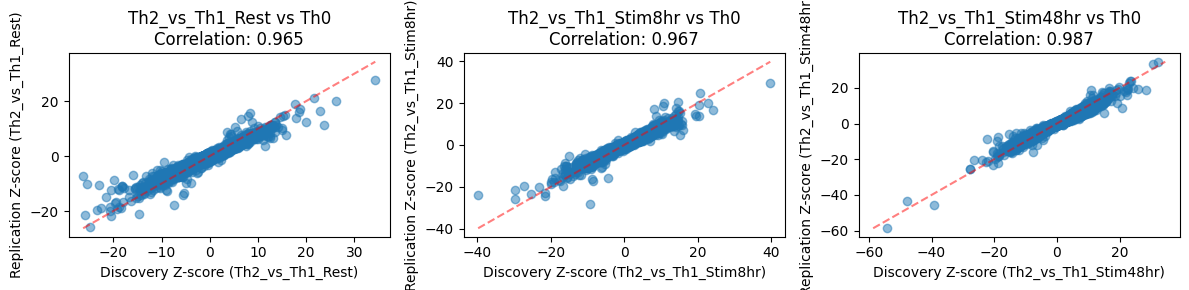

In [23]:
#all_results_df = pd.read_csv("results/discovery_polarization_DE_results.csv")
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']

#all_repl_results_df = pd.read_csv("results/replication_polarization_DE_results.csv")
all_repl_results_df['zscore'] = all_repl_results_df['log_fc']/all_repl_results_df['lfcSE']

# Compare z-scores between discovery and replication results for each condition
conditions = ['Th2_vs_Th1_Rest', 'Th2_vs_Th1_Stim8hr', 'Th2_vs_Th1_Stim48hr', ]

fig, ax = plt.subplots(1,3,figsize=(12,3))
ax = ax.flatten()
for i, cond in enumerate(conditions):
    # Get discovery and replication results for this condition
    disc_results = all_results_df[all_results_df['contrast'] == cond]
    repl_results = all_repl_results_df[all_repl_results_df['contrast'] == cond]
    
    # Merge on gene name to compare z-scores
    merged = pd.merge(disc_results, repl_results, 
                     on='variable', 
                     suffixes=('_disc', '_repl'))
    
    ax[i].scatter(merged['zscore_disc'], merged['zscore_repl'], alpha=0.5)
    ax[i].set_xlabel(f'Discovery Z-score ({cond})')
    ax[i].set_ylabel(f'Replication Z-score ({cond})')
    
    # Add correlation coefficient
    corr = merged['zscore_disc'].corr(merged['zscore_repl'])
    ax[i].set_title(f'{cond} vs Th0\nCorrelation: {corr:.3f}')
    
    # Add diagonal line
    min_val = min(merged['zscore_disc'].min(), merged['zscore_repl'].min())
    max_val = max(merged['zscore_disc'].max(), merged['zscore_repl'].max())
    ax[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
plt.tight_layout()
plt.show()

In [ ]:
# #all_results_df = pd.read_csv("results/discovery_polarization_DE_results.csv")
# all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']

# #all_repl_results_df = pd.read_csv("results/replication_polarization_DE_results.csv")
# all_repl_results_df['zscore'] = all_repl_results_df['log_fc']/all_repl_results_df['lfcSE']

# # Compare z-scores between discovery and replication results for each condition
# conditions = ['Mix_vs_Th0_Rest', 'Mix_vs_Th0_Stim8hr', 'Mix_vs_Th0_Stim48hr', 
#              'Th1_vs_Th0_Rest', 'Th1_vs_Th0_Stim8hr', 'Th1_vs_Th0_Stim48hr', 
#              'Th2_vs_Th0_Rest', 'Th2_vs_Th0_Stim8hr', 'Th2_vs_Th0_Stim48hr', ]

# fig, ax = plt.subplots(3,3,figsize=(9,9))
# ax = ax.flatten()
# for i, cond in enumerate(conditions):
#     # Get discovery and replication results for this condition
#     disc_results = all_results_df[all_results_df['contrast'] == cond]
#     repl_results = all_repl_results_df[all_repl_results_df['contrast'] == cond]
    
#     # Merge on gene name to compare z-scores
#     merged = pd.merge(disc_results, repl_results, 
#                      on='variable', 
#                      suffixes=('_disc', '_repl'))
    
#     ax[i].scatter(merged['zscore_disc'], merged['zscore_repl'], alpha=0.5)
#     ax[i].set_xlabel(f'Discovery Z-score ({cond})')
#     ax[i].set_ylabel(f'Replication Z-score ({cond})')
    
#     # Add correlation coefficient
#     corr = merged['zscore_disc'].corr(merged['zscore_repl'])
#     ax[i].set_title(f'{cond} vs Th0\nCorrelation: {corr:.3f}')
    
#     # Add diagonal line
#     min_val = min(merged['zscore_disc'].min(), merged['zscore_repl'].min())
#     max_val = max(merged['zscore_disc'].max(), merged['zscore_repl'].max())
#     ax[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
# plt.tight_layout()
# plt.show()

In [30]:
all_results_df

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,zscore
0,NRP2,2113.413327,6.209682,0.180913,34.324109,3.428881e-258,3.899666e-254,Th2_vs_Th1_Rest,34.324109
1,SLAMF7,1664.189655,-3.768245,0.143452,-26.268256,4.422444e-152,2.514823e-148,Th2_vs_Th1_Rest,-26.268256
2,HOMER2,1588.187559,4.329263,0.166022,26.076446,6.746132e-150,2.557459e-146,Th2_vs_Th1_Rest,26.076446
3,NPDC1,3619.711624,-2.818695,0.108930,-25.876087,1.237966e-147,3.519847e-144,Th2_vs_Th1_Rest,-25.876087
4,IL12RB2,2087.262161,-5.751223,0.226676,-25.372012,5.137663e-142,1.168613e-138,Th2_vs_Th1_Rest,-25.372012
...,...,...,...,...,...,...,...,...,...
11371,EPHB6,686.237293,0.000388,0.187965,0.002062,9.983549e-01,9.987060e-01,Th2_vs_Th1_Stim48hr,0.002062
11372,CTBP2,162.395749,0.000473,0.256099,0.001847,9.985264e-01,9.987898e-01,Th2_vs_Th1_Stim48hr,0.001847
11373,NEPRO,6831.373131,0.000096,0.069513,0.001378,9.989003e-01,9.990760e-01,Th2_vs_Th1_Stim48hr,0.001378
11374,IL24,291.292522,0.000318,0.409953,0.000776,9.993811e-01,9.994345e-01,Th2_vs_Th1_Stim48hr,0.000776


In [89]:
all_results_df[all_results_df.variable=='IFNG']

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,zscore
52,IFNG,2375.479162,-8.393492,0.569853,-14.729234,4.184215e-49,8.978693e-47,Th2_vs_Th1_Rest,-14.729234
29,IFNG,205312.518984,-8.200471,0.506023,-16.205722,4.594604e-59,1.742274e-56,Th2_vs_Th1_Stim8hr,-16.205722
1,IFNG,103782.418184,-8.924997,0.164990,-54.094213,0.000000e+00,0.000000e+00,Th2_vs_Th1_Stim48hr,-54.094213


In [217]:
test = pd.merge(all_results_ota_df[all_results_ota_df.adj_p_value<1e-2][['variable', 'zscore']],
                all_results_df[(all_results_df.adj_p_value<1e-2)&(all_results_df.contrast=='Th2_vs_Th1_Rest')][['variable', 'zscore']],
                left_on='variable',
                right_on='variable')
test = test.fillna(0)

In [218]:
test

,variable,zscore_x,zscore_y
0,CCR4,55.869751,21.717119
1,GZMK,-40.699941,-5.934091
2,F2R,-42.552850,-13.581048
3,ADRB2,-44.167225,-7.554092
4,LYAR,-58.090505,-13.136328
...,...,...,...
1316,NPM3,3.004790,3.691201
1317,C1orf112,3.001009,4.056866
1318,HEMGN,3.000344,8.157444
1319,IMPA2,2.996823,3.406796


PearsonRResult(statistic=0.44684603229910147, pvalue=7.865856844046435e-66)

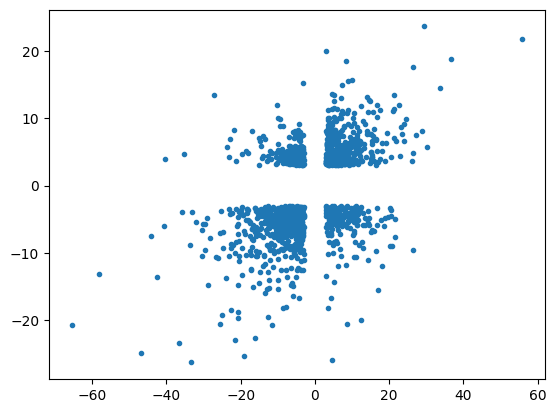

In [220]:
plt.plot(test['zscore_x'], test['zscore_y'], '.')
pearsonr(test['zscore_x'], test['zscore_y'])

NaNs encountered, dropping rows with NaNs


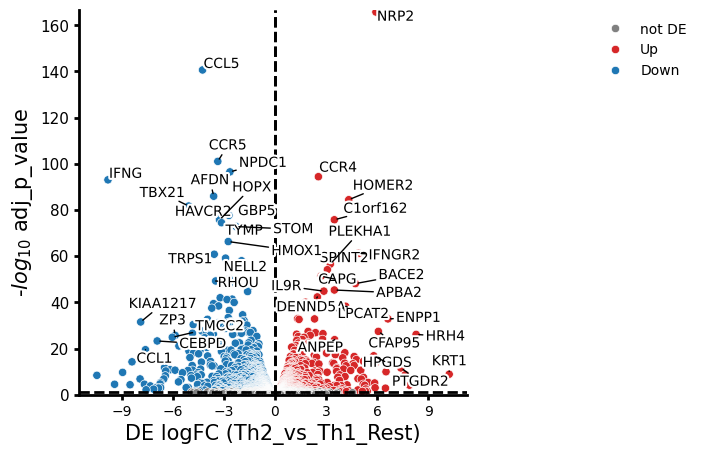

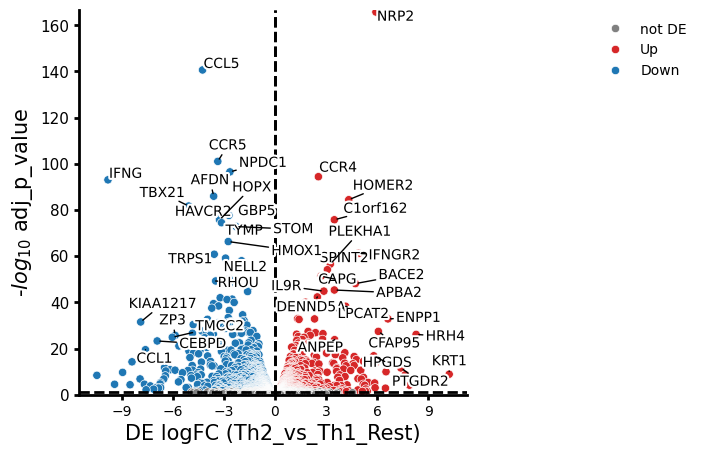

In [86]:
res_df = all_repl_results_df[all_repl_results_df.contrast=='Th2_vs_Th1_Rest'].copy()
p = res_df['contrast'].iloc[0]
model.plot_volcano(
    res_df, 
    log2fc_thresh=0, 
    return_fig=True, 
    x_label=f"DE logFC ({p})",
    to_label = 20,
    )

In [162]:
all_repl_results_df[all_repl_results_df.variable=='SEMA5A']

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,zscore


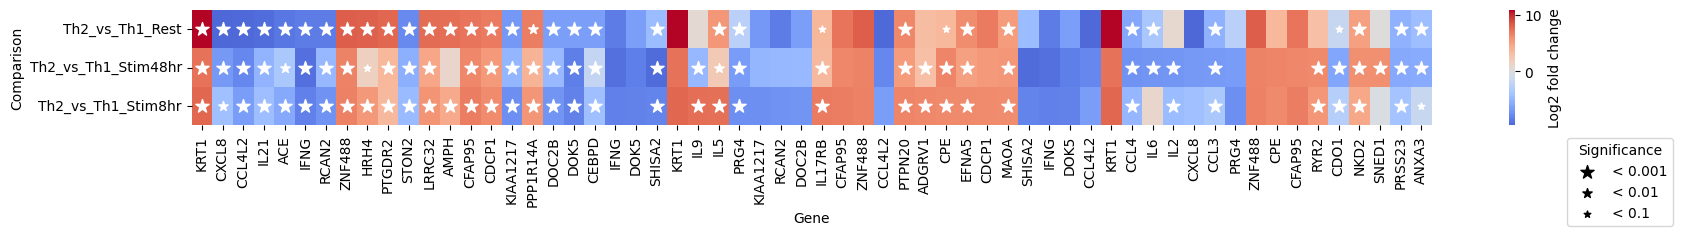

In [88]:
all_results = pd.concat(result_dfs)
all_results['adj_p_value'] = all_results['adj_p_value'].fillna(1)
model.plot_multicomparison_fc(all_results, figsize=(20, 1.5), n_top_vars=20, xticklabels=True, x_label = "Gene", y_label='Comparison')

### Comparison of polarization signatures

In [222]:
combined_signatures = pd.merge(all_results_hollbacher_df[['variable', 'adj_p_value', 'zscore']],
                               all_results_ota_df[['variable', 'adj_p_value', 'zscore']],
                               left_on='variable',
                               right_on='variable', 
                               suffixes=('_hollbacher', '_ota'))
combined_signatures = pd.merge(combined_signatures,
                               all_results_df[all_results_df.contrast=='Th2_vs_Th1_Rest'][['variable', 'adj_p_value', 'zscore']],
                               left_on='variable',
                               right_on='variable')
combined_signatures.columns = ['gene_name', 'padj_hollbacher', 'zscore_hollbacher', 'padj_ota', 'zscore_ota', 'padj_Diff043', 'zscore_Diff043']

In [239]:
signif_thres = 0.05
combined_signatures_signif = pd.merge(all_results_hollbacher_df[['variable', 'adj_p_value', 'zscore']],
                                      all_results_ota_df[all_results_ota_df.adj_p_value<signif_thres][['variable', 'adj_p_value', 'zscore']],
                                      left_on='variable',
                                      right_on='variable', 
                                      suffixes=('_hollbacher', '_ota'))
combined_signatures_signif = pd.merge(combined_signatures_signif,
                                      all_results_df[(all_results_df.adj_p_value<signif_thres)&(all_results_df.contrast=='Th2_vs_Th1_Rest')][['variable', 'adj_p_value', 'zscore']],
                                      left_on='variable',
                                      right_on='variable')
combined_signatures_signif.columns = ['gene_name', 'padj_hollbacher', 'zscore_hollbacher', 'padj_ota', 'zscore_ota', 'padj_Diff043', 'zscore_Diff043']

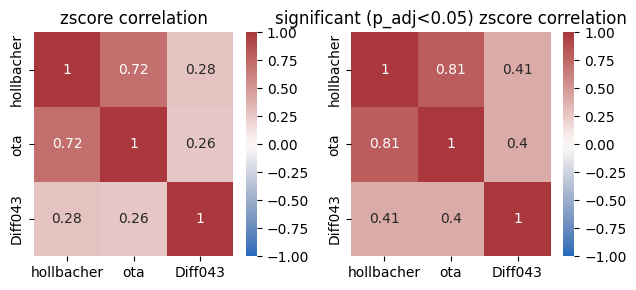

In [240]:
fig, ax = plt.subplots(1,2,figsize=(6.5,3))
sns.heatmap(combined_signatures[['zscore_hollbacher', 'zscore_ota', 'zscore_Diff043']].corr(),
            annot=True,
            center=0,
            xticklabels=['hollbacher', 'ota', 'Diff043'],
            yticklabels=['hollbacher', 'ota', 'Diff043'],
            cmap='vlag',
            vmin=-1,
            vmax=1,
            ax=ax[0])
ax[0].set_title('zscore correlation')

sns.heatmap(combined_signatures_signif[['zscore_hollbacher', 'zscore_ota', 'zscore_Diff043']].corr(),
            annot=True,
            center=0,
            xticklabels=['hollbacher', 'ota', 'Diff043'],
            yticklabels=['hollbacher', 'ota', 'Diff043'],
            cmap='vlag',
            vmin=-1,
            vmax=1,
            ax=ax[1])
ax[1].set_title('significant (p_adj<0.05) zscore correlation')

plt.tight_layout()

In [241]:
combined_signatures_signif

,gene_name,padj_hollbacher,zscore_hollbacher,padj_ota,zscore_ota,padj_Diff043,zscore_Diff043
0,TBX21,2.558741e-27,-11.590989,1.371920e-290,-36.630762,2.390809e-118,-23.439750
1,GZMK,2.735849e-17,-9.338291,0.000000e+00,-40.699941,4.680324e-08,-5.934091
2,LYAR,1.032448e-12,-8.098987,0.000000e+00,-58.090505,3.051003e-37,-13.136328
3,GNLY,2.320809e-11,-7.691574,2.762516e-83,-19.578501,2.475290e-38,-13.326088
4,EOMES,2.306847e-10,-7.374390,0.000000e+00,-40.299724,6.839965e-04,3.884069
...,...,...,...,...,...,...,...
1698,JUN,NaN,-0.313492,2.279293e-08,-5.955239,5.263910e-58,-16.405085
1699,NFKBID,NaN,0.202860,1.919595e-06,-5.139626,2.309610e-03,-3.535391
1700,RHOB,NaN,-0.196940,7.177238e-03,-3.096717,3.877044e-20,-9.610396
1701,RORC,NaN,-0.585678,7.178763e-17,-8.668179,9.588959e-06,-4.911131


In [242]:
combined_signatures.to_csv('results/combined_Th2_vs_Th1_signature.csv', index=False)